# Siamese-FC

In [96]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Lambda, Reshape, Flatten
from keras.models import Model

**Build Model**

In [97]:
def conv_layer(filters, kernel_dim, stride_len):
    return [Conv2D(filters, kernel_dim, strides=stride_len,
                  padding='valid', activation='relu', kernel_initializer='glorot_normal')]

def conv_block(filters, kernel_dim, stride_len):
    batch_norm = [BatchNormalization(axis=3)]
    return conv_layer(filters, kernel_dim, stride_len) + batch_norm

def max_pool():
    return [MaxPool2D(pool_size=3, strides=2, padding='valid')]

def alex_net_layers():
    layers = []
    layers += conv_block(48, 11, 2)
    layers += max_pool()
    layers += conv_block(128, 5, 1)
    layers += max_pool()
    layers += conv_block(48, 3, 1)
    layers += conv_block(48, 3, 1)
    layers += conv_layer(32, 3, 1)
    return layers

def apply_layers(x, layers):
    out = x
    for layer in layers:
        out = layer(out)
    return out

def add_dimension(t):
    return tf.reshape(t, (1,) + t.shape)

def cross_correlation(inputs):
    x = inputs[0]
    x = tf.reshape(x, [1] + x.shape.as_list())
    z = inputs[1]
    z = tf.reshape(z, z.shape.as_list() + [1])
    return tf.nn.convolution(x, z, padding='VALID', strides=(1,1))

def x_corr_map(inputs):
    # Note that dtype MUST be specified, otherwise TF will assert that the input and output structures are the same,
    # which they most certainly are NOT.
    return tf.map_fn(cross_correlation, inputs, dtype=tf.float32, infer_shape=False)
    
def x_corr_layer():
    return Lambda(x_corr_map, output_shape=(1, 17, 17, 1))
    
exemplar = Input(shape=(127, 127, 3))
search = Input(shape=(255, 255, 3))

alex_net = alex_net_layers()

exemplar_features = apply_layers(exemplar, alex_net)
search_features = apply_layers(search, alex_net)

In [98]:
kernel_shape = (3,3,3)
target_shape = (5,5,3)

kernel = Input(shape=kernel_shape)
target = Input(shape=target_shape)

kernel_input = np.empty((2,) + kernel_shape)
kernel_input[0] = np.ones(kernel_shape)
kernel_input[1] = np.full(kernel_shape, 2)

target_input = np.empty((2,) + target_shape)
target_input[0] = np.ones(target_shape)
target_input[1] = np.ones(target_shape)

out = Lambda(x_corr_map)([target, kernel])
flat = Flatten()(out)

model = Model(inputs=[target, kernel], outputs=flat)
print(model.predict([target_input, kernel_input]))


[[ 27.  27.  27.  27.  27.  27.  27.  27.  27.]
 [ 54.  54.  54.  54.  54.  54.  54.  54.  54.]]


In [99]:
score_map = x_corr_layer()([search_features, exemplar_features])
flat = Flatten()(score_map)
model = Model(inputs=[search, exemplar], outputs=flat)

test_exemplar = np.ones((2,127,127,3))
test_search = np.ones((2,255,255,3))

model.predict([test_search, test_exemplar]).shape

(2, 289)

In [100]:
conv_test = Model(inputs=[search, exemplar], outputs=[search_features, exemplar_features])
outs = conv_test.predict([test_search, test_exemplar])
exemplar_test = Model(inputs=exemplar, outputs=apply_layers(exemplar, alex_net_layers()))
search_test = Model(inputs=search, outputs=apply_layers(search, alex_net_layers()))
print(outs[0].shape)
print(outs[1].shape)

(2, 22, 22, 32)
(2, 6, 6, 32)


In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [122]:
from keras.preprocessing import image

x_dir = '../sample/x/'
z_dir = '../sample/z/'

def load_images(directory, dimension, n_images, suffix):
    img_array = np.empty((n_images, dimension, dimension, 3))
    for i in range(1, n_images + 1):
        img = image.load_img(directory + str(i) + suffix, target_size=(dimension, dimension))
        img_array[i - 1] = image.img_to_array(img)
    return img_array

In [14]:
search = load_images(x_dir, 255, 100, ".x.jpg")

In [15]:
exemplar = load_images(z_dir, 127, 100, ".z.jpg")

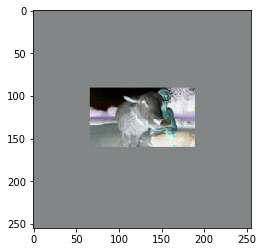

In [16]:
plt.imshow(search[0])

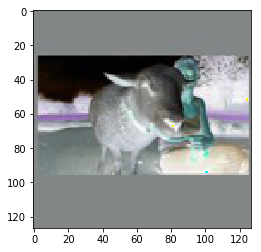

In [17]:
plt.imshow(exemplar[0])

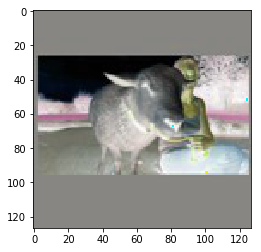

In [18]:
plt.imshow(np.flip(exemplar[0], axis=2))

**Make label prototype for search images**

In [105]:
from math import ceil
def inclusive_range(start, end):
    return range(start, end + 1)

def euclidean_distance(x1, y1, x2, y2):
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Create labels for a score map of size dim x dim, where the label of a score is positive for any cell within
# radius of the center, and negative otherwise.
def make_label(dim, radius):
    label = np.full((dim, dim), -1)
    center = int(dim / 2.0)
    start = center - ceil(radius)
    end = center + ceil(radius)
    for i in inclusive_range(start, end):
        for j in inclusive_range(start, end):
            if euclidean_distance(i, j, center, center) <= radius:
                label[i,j] = 1
    return label

# Creates a matrix of weights where the sum of the weights for each label in {-1, 1} is 0.5. Used to account for
# the fact that, given a search image we may have more negative than positive examples or vice versa.
def make_label_weights(labels):
    values, counts = np.unique(labels, return_counts=True)
    class_weights = {}
    for i in range(len(values)):
        class_weights[values[i]] = 0.5 / counts[i]
    return class_weights

In [55]:
print(make_label(5, 1))

[[-1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1]
 [-1  1  1  1 -1]
 [-1 -1  1 -1 -1]
 [-1 -1 -1 -1 -1]]


In [56]:
print(make_label_weights(make_label(5,1)))

(0.10000000000000001, 0.025000000000000001)


In [94]:
class SiameseFC(object):
    X_SHAPE = (255, 255, 3)
    Z_SHAPE = (127, 127, 3)
    
    def __init__(self):
        conv_layers = self._conv_layers()
        x = self._input(self.X_SHAPE)
        z = self._input(self.Z_SHAPE)
        x_features = self._apply_layers(x, conv_layers)
        z_features = self._apply_layers(z, conv_layers)
        scores = Flatten()(self._cross_correlation([x_features, z_features]))
        print(scores)
        self.model = Model(inputs=[x, z], outputs=scores)
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def predict(self, x):
        return self.model.predict(x)
        
    def _input(self, shape):
        return Input(shape=shape)
    
    def _conv_layer(self, filters, kernel_dim, stride_len):
        return [Conv2D(filters, kernel_dim, strides=stride_len,
                  padding='valid', activation='relu', kernel_initializer='glorot_normal')]

    def _conv_block(self, filters, kernel_dim, stride_len):
        batch_norm = [BatchNormalization(axis=3)]
        return self._conv_layer(filters, kernel_dim, stride_len) + batch_norm

    def _max_pool(self):
        return [MaxPool2D(pool_size=3, strides=2, padding='valid')]

    def _conv_layers(self):
        layers = []
        layers += self._conv_block(48, 11, 2)
        layers += self._max_pool()
        layers += self._conv_block(128, 5, 1)
        layers += self._max_pool()
        layers += self._conv_block(48, 3, 1)
        layers += self._conv_block(48, 3, 1)
        layers += self._conv_layer(32, 3, 1)
        return layers

    def _apply_layers(self, x, layers):
        out = x
        for layer in layers:
            out = layer(out)
        return out

    def _add_dimension(self, t):
        return tf.reshape(t, (1,) + t.shape)

    def _cross_correlation_fn(self, inputs):
        x = inputs[0]
        x = tf.reshape(x, [1] + x.shape.as_list())
        z = inputs[1]
        z = tf.reshape(z, z.shape.as_list() + [1])
        return tf.nn.convolution(x, z, padding='VALID', strides=(1,1))

    def _cross_correlation(self, inputs):
        # Note that dtype MUST be specified, otherwise TF will assert that the input and output structures are the same,
        # which they most certainly are NOT.
        return tf.map_fn(self._cross_correlation_fn, inputs, dtype=tf.float32, infer_shape=False)

In [95]:
sfc = SiameseFC()

Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)


AttributeError: 'NoneType' object has no attribute 'inbound_nodes'

In [104]:
R =  16
label = make_label(17, R / 6.0)
print(label)

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


In [107]:
label_weights = make_label_weights(label)
print(label_weights)

{1: 0.023809523809523808, -1: 0.0018656716417910447}


In [108]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [111]:
def make_models(x_shape, z_shape):
    x = Input(shape=x_shape)
    z = Input(shape=z_shape)
    x_feat = apply_layers(alex_net_layers(), x)
    z_feat = apply_layers(axle_net_layers(), z)
    scores = Lamba(x_corr_map)([x_feat,z_feat])
    flat = Flatten()(scores)
    return Model(inputs=[x,z], outputs=flat)

# test how flatten works
test_in = Input(shape=(5,5,1))
test_out = Flatten()(test_in)

flatifier = Model(inputs=test_in, outputs=test_out)
labels = make_label(5,1)
print(labels)

[[-1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1]
 [-1  1  1  1 -1]
 [-1 -1  1 -1 -1]
 [-1 -1 -1 -1 -1]]


In [115]:
labels[np.where(labels == -1)] = 0
flatifier.predict(np.reshape(labels, (1,5,5,1)))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

**Attempting to train**

In [123]:
x_images = load_images(x_dir, 255, 100, ".x.jpg")
z_images = load_images(z_dir, 127, 100, ".z.jpg")

In [132]:
# constants
batch_size = 1
response_size = 17
data_size = 100
response_stride = 6.0
label = make_label(response_size, R / response_stride).flatten()
labels = np.empty((data_size,) + label.shape)
labels[:] = label
labels[np.where(labels==-1)] = 0
print(labels.shape)
print(labels[0], labels[1])

(100, 289)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [133]:
model.fit([x_images, z_images], labels, batch_size=batch_size, epochs=10, validation_split=0.1)

Train on 90 samples, validate on 10 samples
Epoch 1/10
67/90 [=====================>........] - ETA: 3s - loss: 14.7839 - acc: 0.0000e+00

KeyboardInterrupt: 